In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.layers.experimental import preprocessing
from risk_model import Model
from datetime import datetime
import riskfolio as rp
from pandas_datareader import data as pdr
%matplotlib inline

from absl import logging
tf.get_logger().setLevel('ERROR')

float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
tf.random.set_seed(123)

np.random.seed(123)
yf.pdr_override()  # <== that's all it takes :-)


very_small_float = 1.0 #0.000000001

2022-09-24 14:07:41.795294: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-24 14:07:41.795346: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from bt_testcode import backtest, DynRebalance, get_name, plotAllocation, getStatistic, calc_portfolio_values
from bt_testcode import plotPortfolioReturns, get_portfolio_values

# Test Model

In [3]:
ticker = """AXISBANK.NS	BPCL.NS	BRITANNIA.NS	CIPLA.NS	DRREDDY.NS	EICHERMOT.NS	GAIL.NS	HDFCBANK.NS	HINDALCO.NS	HINDUNILVR.NS	INFY.NS	IOC.NS	ITC.NS	M&M.NS	MARICO.NS	ONGC.NS	RELIANCE.NS	SAIL.NS	SBIN.NS	SIEMENS.NS	SUNPHARMA.NS	TATACONSUM.NS	TATAMOTORS.NS	TATAPOWER.NS	TATASTEEL.NS	TITAN.NS VEDL.NS	WIPRO.NS""".split()
benchmark_index = "^BSESN"
history_range = {'start': datetime(2000, 1, 1), 
                 'end': datetime(2022, 7, 31)}

stock = pdr.DataReader(ticker, 
                start=history_range['start'],
                end=history_range['end'],
                data_source='yahoo')

[*********************100%***********************]  28 of 28 completed


In [4]:
stock_close = stock.iloc[:126]['Close'].fillna(very_small_float)
stock_close.head()

,AXISBANK.NS,BPCL.NS,BRITANNIA.NS,CIPLA.NS,DRREDDY.NS,EICHERMOT.NS,GAIL.NS,HDFCBANK.NS,HINDALCO.NS,HINDUNILVR.NS,...,SBIN.NS,SIEMENS.NS,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATAPOWER.NS,TATASTEEL.NS,TITAN.NS,VEDL.NS,WIPRO.NS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,5.18,33.270832,75.690002,116.587997,377.062500,4.885,8.587504,17.000000,73.833130,230.755005,...,22.988886,54.494999,14.214153,56.450001,41.535931,7.406506,8.559305,7.7850,2.90875,102.157501
2000-01-04,5.38,30.875000,75.455002,117.220001,407.237488,5.140,8.293754,17.379999,76.633423,228.104996,...,24.446625,54.654999,14.023603,55.090000,39.897491,7.420981,8.466666,7.3700,2.86750,110.330627
2000-01-05,5.24,29.995832,73.529999,114.804001,392.012512,5.555,7.900003,16.695000,82.761711,219.990005,...,23.441774,52.250000,13.531350,52.794998,40.865227,7.565734,8.789500,6.9200,2.85000,112.128754
2000-01-06,5.11,31.691666,78.565002,108.468002,415.387512,6.000,8.118754,16.830000,89.238976,228.820007,...,24.625893,53.000000,13.518182,54.560001,42.561157,7.802163,9.446396,7.4750,2.98250,109.959381
2000-01-07,4.86,31.654165,84.849998,99.804001,382.274994,6.465,7.831253,16.834999,93.196831,241.294998,...,25.786425,48.779999,12.436851,58.910000,45.972179,7.787688,9.654133,7.3175,2.91250,101.163757


In [5]:
import matplotlib.pyplot as plt
rnd = 8
tf.random.set_seed(rnd)
np.random.seed(rnd)

param={}
param ={'model_params':
    {'model_n':'LSTM',
    'epochs':1000}}

m = Model()
alloc = m.get_allocations(stock_close.values, **param['model_params'])
print(alloc)

2022-09-24 14:08:08.895334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-24 14:08:08.895394: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-24 14:08:08.895435: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (divyanshu-PC): /proc/driver/nvidia/version does not exist


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

[0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000
 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]


/home/divyanshu/Documents/GitHub/BTP/lib/python3.10/site-packages/riskfolio/PlotFunctions.py:568: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


ZeroDivisionError: integer division or modulo by zero

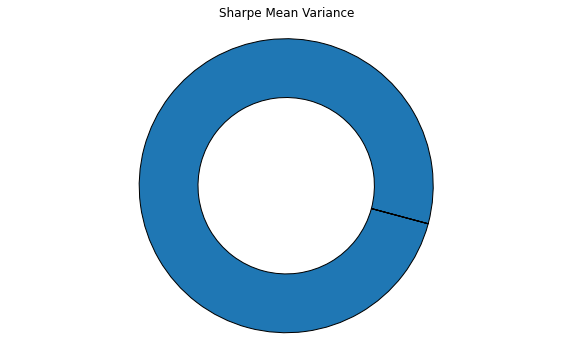

In [6]:

df = pd.DataFrame(alloc, index=ticker)
ax = rp.plot_pie(w=df, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap="tab20",
                 height=6, width=10, ax=None)

,AXISBANK.NS,BPCL.NS,BRITANNIA.NS,CIPLA.NS,DRREDDY.NS,EICHERMOT.NS,GAIL.NS,HDFCBANK.NS,HINDALCO.NS,HINDUNILVR.NS,...,SBIN.NS,SIEMENS.NS,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATAPOWER.NS,TATASTEEL.NS,TITAN.NS,VEDL.NS,WIPRO.NS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,0.038610,-0.072010,-0.003105,0.005421,0.080026,0.052201,-0.034207,0.022353,0.037927,-0.011484,...,0.063411,0.002936,-0.013406,-0.024092,-0.039446,0.001954,-0.010823,-0.053308,-0.014181,0.080005
2000-01-05,-0.026022,-0.028475,-0.025512,-0.020611,-0.037386,0.080739,-0.047476,-0.039413,0.079969,-0.035576,...,-0.041104,-0.044003,-0.035102,-0.041659,0.024256,0.019506,0.038130,-0.061058,-0.006103,0.016298
2000-01-06,-0.024809,0.056536,0.068476,-0.055190,0.059628,0.080108,0.027690,0.008086,0.078264,0.040138,...,0.050513,0.014354,-0.000973,0.033431,0.041501,0.031250,0.074736,0.080202,0.046491,-0.019347
2000-01-07,-0.048924,-0.001183,0.079997,-0.079876,-0.079715,0.077500,-0.035412,0.000297,0.044351,0.054519,...,0.047126,-0.079623,-0.079991,0.079729,0.080144,-0.001855,0.021991,-0.021070,-0.023470,-0.079990
2000-01-10,0.030864,0.013426,0.075074,-0.033385,-0.016480,0.013148,-0.005587,-0.014553,-0.065802,0.007584,...,-0.013904,-0.018245,-0.045933,0.008827,0.078991,0.070012,0.059901,-0.009908,0.021459,0.001353


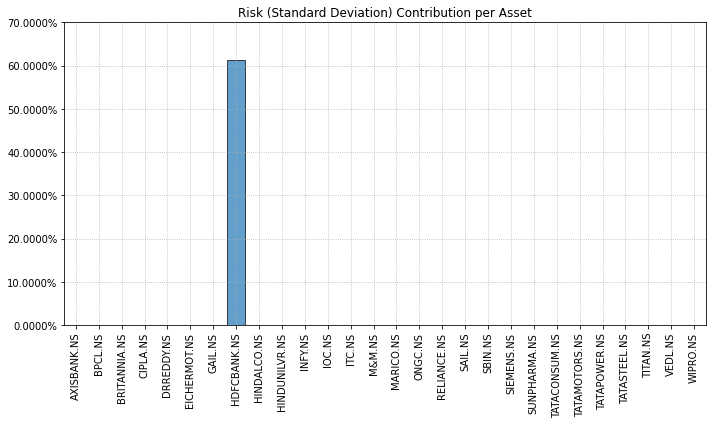

In [7]:
Y = stock_close.pct_change().dropna()
display(Y.head())
port = rp.Portfolio(returns=Y)
method_mu = 'hist'
# Method to estimate covariance matrix based on historical data.
method_cov = 'hist'

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

ax = rp.plot_risk_con(w=df, cov=port.cov, returns=Y, rm='MV',
                      rf=0, alpha=0.05, color="tab:blue", height=6,
                      width=10, t_factor=252, ax=None)


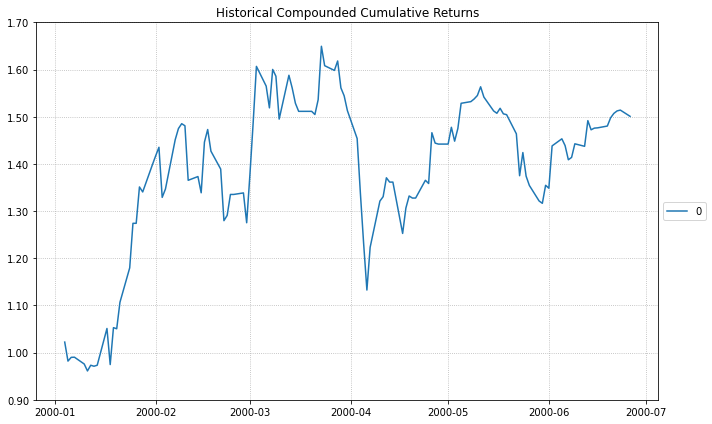

In [8]:
cagr_graph = rp.plot_series(returns=Y, w=df, cmap='tab20', height=6, width=10,
                            ax=None)


In [12]:
calc_portfolio_values(alloc, stock_close)

portfolio_returns: 0.5077
std: 0.0387
sharpe: 0.1059


In [ ]:
config_cerebro = {
    'assets': ticker,
    #'assets':['SPY', 'TLT', 'GLD', 'BA', 'SLV', 'WYNN','MO', 'AEE', 'AIG', 'WY'],
    'benchmark': benchmark_index,
    'startd': history_range['start'],
    'endd': history_range['end'],
    'set_coc' : True,
    'set_coo' : False,
    'cash': 1000000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'LSTM',
        'collectData':False,
        'epochs':1000}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

[*********************100%***********************]  28 of 28 completed
[*********************100%***********************]  1 of 1 completed


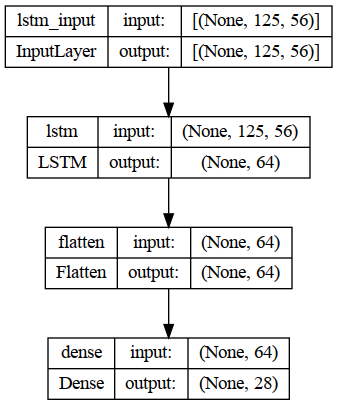

In [9]:
tf.keras.utils.plot_model(m.getModel(), show_shapes=True)


Starting Portfolio Value: 1000000.00
Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0637
Epoch 2/1000
1/1 [==============================] - 0s 36ms/step - loss: -0.0294
Epoch 3/1000
1/1 [==============================] - 0s 41ms/step - loss: -0.1083
Epoch 4/1000
1/1 [==============================] - 0s 38ms/step - loss: -0.1139
Epoch 5/1000
1/1 [==============================] - 0s 35ms/step - loss: -0.1128
Epoch 6/1000
1/1 [==============================] - 0s 42ms/step - loss: -0.1097
Epoch 7/1000
1/1 [==============================] - 0s 44ms/step - loss: -0.1088
Epoch 8/1000
1/1 [==============================] - 0s 37ms/step - loss: -0.1087
Epoch 9/1000
1/1 [==============================] - 0s 40ms/step - loss: -0.1087
Epoch 10/1000
1/1 [==============================] - 0s 50ms/step - loss: -0.1087
Epoch 11/1000
1/1 [==============================] - 0s 46ms/step - loss: -0.1087
Epoch 12/1000
1/1 [==============================] - 0s 55ms/step - loss:

,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM,19.698725,55.340629,0.236357,5.609930e+07


<AxesSubplot: xlabel='data'>

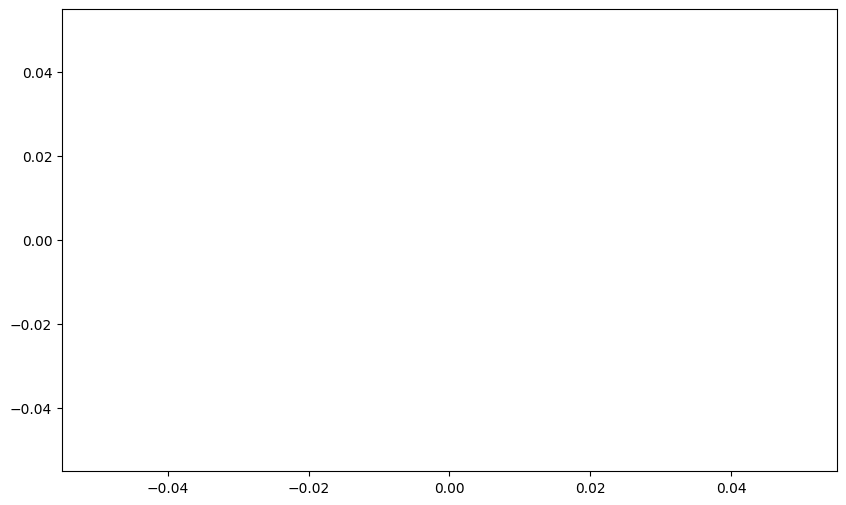

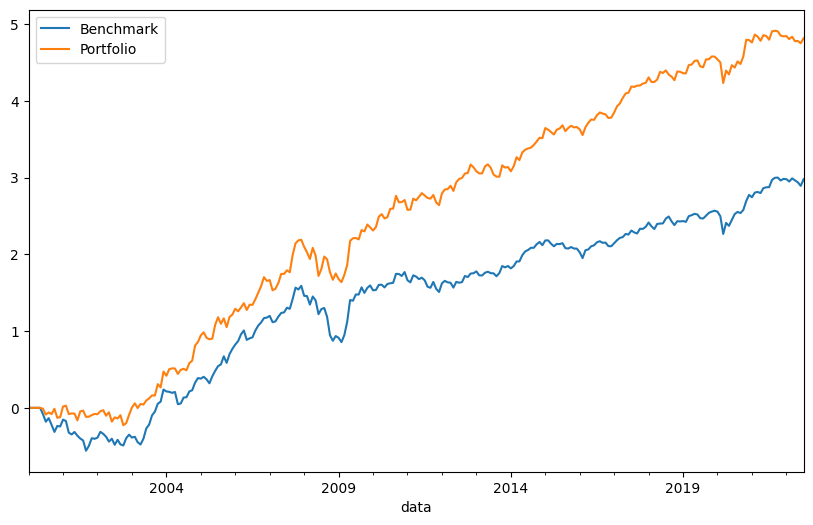

In [ ]:
import matplotlib.pyplot as plt
params['model'] = Model()
params['resetModel'] = False
%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 6)  # (w, h)
plt.plot()
d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()
